In [1]:
from scipy.constants import metric_ton
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pickle
import functools
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from DBUtil import DBConnection
from RawEyeData import RawEyeData
from RawSlideData import RawSlideData
from EyeData import EyeData
from SlideData import SlideData

%matplotlib inline

In [3]:
overwrite_files = True

Import eye tracking data

In [265]:
# Establish connection to MySQL database server
connection = DBConnection("localhost", "root", "Whedon101")

MySQL Database Connection Successful!


In [5]:
# Connection to alternate database server
alt_connection = DBConnection("172.30.6.59", "xper_rw", "up2nite")

MySQL Database Connection Successful!


In [310]:
# Import eye data and slide data
db_name = '20231011_recording'
left_eye_data, right_eye_data = RawEyeData().get(db_name)
slide_data = RawSlideData().get(db_name)

# Grab screen dimensions for converting eye data from degrees to mm
screen_distance_mm = connection.get_column_from_table('val', f'{db_name}.SystemVar', 'name', 'xper_monkey_screen_distance', int)
screen_width_mm = connection.get_column_from_table('val', f'{db_name}.SystemVar', 'name', 'xper_monkey_screen_width', int)
screen_height_mm = connection.get_column_from_table('val', f'{db_name}.SystemVar', 'name', 'xper_monkey_screen_height', int)
dynamic_image_size_mm = connection.get_column_from_table('val', f'{db_name}.SystemVar', 'name', 'xper_dynamic_image_size', int)

MySQL Database Connection Successful!
MySQL Database Connection Successful!
done


If importing processed data from saved pickle files

In [86]:
# Get list of all available pre-processed recording days
file_list_name = f'/Users/joseph/Documents/GitHub/data/eye_trace_file_list.txt'
with open(file_list_name, 'r') as file:
    db_list = [line.strip().split('.')[0] for line in file]

In [267]:
db_list

['20230926_recording',
 '20230928_recording',
 '20230929_recording',
 '20231003_recording',
 '20231004_recording',
 '20231005_recording',
 '20231009_recording',
 '20231010_recording',
 '20231011_recording']

In [309]:
file_dir = f'/Users/joseph/Documents/GitHub/data/eye_trace'
db_name = '20231011_recording'
if os.path.exists(f'{file_dir}/{db_name}.pkl'):
    with open(f'{file_dir}/{db_name}.pkl', 'rb') as file:
        left_eye_trial_data, right_eye_trial_data, slide_trial_data, left_eye_proportion_on_face_all_trials, right_eye_proportion_on_face_all_trials,\
        mean_eye_proportion_on_face_all_trials, face_area_proportion_all_trials, mean_eye_proportion_on_face_per_monkey_all_trials,\
        mean_eye_proportion_on_face_full_face_zombies, mean_eye_proportion_on_face_no_face_zombies = pickle.load(file)
n_trials = slide_trial_data.time.shape[0]

Format and split eye tracking data into individual trials

In [ ]:
# Important parameters
screen_width_pixel, screen_height_pixel = 3840, 2160  # 4k resolution
orig_img_width_pixel, orig_img_height_pixel = 5472, 3648  # 19.9 megapixels

In [7]:
# Important functions for converting eye tracking units
def deg2mm(deg, dist):
    return np.tan(deg * np.pi / 180) * dist

def get_image_size_mm(img_width, img_height, head_height, dynamic_img_size, screen_distance):
    desired_perception_distance = 1000  # mm
    actual_monkey_head_height = 120  # mm
    display_head_height = screen_distance * actual_monkey_head_height / desired_perception_distance
    if head_height == 0 and (img_width < img_height):  # portrait
        display_img_height = dynamic_img_size
        display_img_width = display_img_height * img_width / img_height
    elif head_height == 0 and (img_width >= img_height):  # landscape
        display_img_width = dynamic_img_size
        display_img_height = display_img_width * img_height / img_width
    else:
        display_img_height = display_head_height * img_height / head_height
        display_img_width = display_img_height * img_width / img_height
    return display_img_width, display_img_height

def mm2pixel(mm, dim_mm, dim_pix):
    width_mm, height_mm = dim_mm
    width_pix, height_pix = dim_pix
    pixel = np.copy(mm)
    pixel[:,0] = np.round(pixel[:,0] * width_pix / width_mm + width_pix / 2)
    pixel[:,1] = np.round(pixel[:,1] * height_pix / height_mm + height_pix / 2)
    pixel[(pixel[:,0] < 0) | (pixel[:,0] >= width_pix)] = np.nan
    pixel[(pixel[:,1] < 0) | (pixel[:,1] >= height_pix)] = np.nan
    return pixel

In [311]:
# Filter out non-monkey photo trials and update file path on a new SlideData object
new_img_path = '/Users/joseph/Documents/GitHub/OneMonkey'
slide_trial_data = SlideData()
slide_trial_data.set_image_path(slide_data.get_image_path())
trials_to_keep = list()
for trial, image_path in enumerate(slide_data.get_image_path()):
    folder_name, file_name = image_path.split('/')[-2:]
    if folder_name == 'OneMonkey' and 'macaque' not in file_name:
        trials_to_keep.append(trial)
        file_name = image_path.split('/')[-1]
        slide_trial_data.image_path[trial] = f'{new_img_path}/{file_name}'

# Apply trial filter on new SlideData object
slide_trial_data.set_image_path(slide_data.image_path[trials_to_keep])
slide_trial_data.set_task_id(slide_data.task_id[trials_to_keep])
slide_trial_data.set_time(slide_data.time[trials_to_keep])
slide_trial_data.set_width(slide_data.width[trials_to_keep])
slide_trial_data.set_height(slide_data.height[trials_to_keep])
slide_trial_data.set_head_height(slide_data.head_height[trials_to_keep])
n_trials = slide_trial_data.time.shape[0]

# Create new EyeData objects for trial-level eye data
left_eye_trial_data = EyeData()
left_eye_trial_data.set_eye(left_eye_data.get_eye())
left_eye_trial_data.set_unit(left_eye_data.get_unit())
left_eye_trial_data.set_time(list())
left_eye_trial_data.set_coordinates(list())

right_eye_trial_data = EyeData()
right_eye_trial_data.set_eye(right_eye_data.get_eye())
right_eye_trial_data.set_unit(right_eye_data.get_unit())
right_eye_trial_data.set_time(list())
right_eye_trial_data.set_coordinates(list())

# Split eye data into individual trials based on timestamps in slide_trial_data
i, i_max = 0, left_eye_data.time.shape[0]
for trial, (start_time, end_time) in enumerate(slide_trial_data.get_time()):
    # First check if this trial should be dropped
    monkey_id = slide_trial_data.image_path[trial].split('/')[-1].split('.')[0]
    monkey_name = connection.get_column_from_table('monkey_name', 'photo_metadata.monkeys', 'monkey_id', monkey_id, str)
    if monkey_name.startswith('Unknown'):
        continue
    # Move up eye data timestamp pointers until the start of the trial window
    while left_eye_data.time[i] < start_time or right_eye_data.time[i] < start_time:
        i = min(i+1, i_max)
    # Get start and end indexes of eye data timestamps for this trial window
    st = i
    while left_eye_data.time[i] <= end_time and right_eye_data.time[i] <= end_time:
        i = min(i+1, i_max)
    ed = i
    # Slice block of eye data corresponding to this trial
    left_eye_trial_data.time.append(left_eye_data.time[max(st-1,0):min(ed+1,i_max)])
    left_eye_trial_data.coordinates.append(left_eye_data.coordinates[st:ed])
    right_eye_trial_data.time.append(right_eye_data.time[max(st-1,0):min(ed+1,i_max)])
    right_eye_trial_data.coordinates.append(right_eye_data.coordinates[st:ed])
    # i = 0  # in case the slide on/off timestamps are not monotonically increasing for some reason

# Compute elapsed time (duration since previous timestamp) and dwell time (duration to next timestamp) for each eye data point
microseconds_in_a_second = 1_000_000  # remember to convert timestamps to seconds
left_eye_trial_data.elapsed_time = list()
left_eye_trial_data.dwell_time = list()
right_eye_trial_data.elapsed_time = list()
right_eye_trial_data.dwell_time = list()
for trial in range(n_trials):
    left_eye_time = left_eye_trial_data.time[trial]
    right_eye_time = right_eye_trial_data.time[trial]
    # Elapsed time: current timestamp - previous timestamp
    left_eye_trial_data.elapsed_time.append((left_eye_time[1:-1] - left_eye_time[:-2]) / microseconds_in_a_second)
    right_eye_trial_data.elapsed_time.append((right_eye_time[1:-1] - right_eye_time[:-2]) / microseconds_in_a_second)
    # Dwell time: next timestamp - current timestamp
    left_eye_trial_data.dwell_time.append((left_eye_time[2:] - left_eye_time[1:-1]) / microseconds_in_a_second)
    right_eye_trial_data.dwell_time.append((right_eye_time[2:] - right_eye_time[1:-1]) / microseconds_in_a_second)

# Compute eye movement velocities (in deg/s): (current eye coord - previous eye coord) / current elapsed time
left_eye_trial_data.velocities = list()
right_eye_trial_data.velocities = list()
for trial in range(n_trials):
    left_eye_trace = left_eye_trial_data.coordinates[trial]
    right_eye_trace = right_eye_trial_data.coordinates[trial]
    left_eye_elapsed_time = left_eye_trial_data.elapsed_time[trial]
    right_eye_elapsed_time = right_eye_trial_data.elapsed_time[trial]
    left_eye_trial_data.velocities.append(np.linalg.norm(left_eye_trace[1:] - left_eye_trace[:-1], axis=1) / left_eye_elapsed_time[1:])
    right_eye_trial_data.velocities.append(np.linalg.norm(right_eye_trace[1:] - right_eye_trace[:-1], axis=1) / right_eye_elapsed_time[1:])

# Convert eye data coordinates into pixel positions (deg -> mm position on screen -> pixel position on screen)
# will also put NaNs on coordinates that fall outside of the screen boundaries
for trial in range(n_trials):
    img = plt.imread(slide_trial_data.image_path[trial])
    img_height_pixel, img_width_pixel = img.shape[:2]
    img_width_mm, img_height_mm = get_image_size_mm(slide_trial_data.width[trial], slide_trial_data.height[trial], slide_trial_data.head_height[trial],
                                                    dynamic_image_size_mm, screen_distance_mm)
    left_eye_trial_data.coordinates[trial] = mm2pixel(deg2mm(left_eye_trial_data.coordinates[trial], screen_distance_mm),
                                                      (img_width_mm, img_height_mm), (img_width_pixel, img_height_pixel))
    right_eye_trial_data.coordinates[trial] = mm2pixel(deg2mm(right_eye_trial_data.coordinates[trial], screen_distance_mm),
                                                       (img_width_mm, img_height_mm), (img_width_pixel, img_height_pixel))

# # Filter out values in eye movement velocities where the eye position was out of screen (NaNs)
# for trial in range(n_trials):
#     left_eye_trace = left_eye_trial_data.coordinates[trial]
#     right_eye_trace = right_eye_trial_data.coordinates[trial]
#     left_eye_displacement = left_eye_trace[1:] - left_eye_trace[:-1]
#     right_eye_displacement = right_eye_trace[1:] - right_eye_trace[:-1]
#     left_eye_trial_data.velocities[trial][np.any(np.isnan(left_eye_displacement), axis=1)] = np.nan
#     right_eye_trial_data.velocities[trial][np.any(np.isnan(right_eye_displacement), axis=1)] = np.nan

Label fixation and saccadic events in eye tracking data

Text(0.5, 1.0, 'Trial 153')

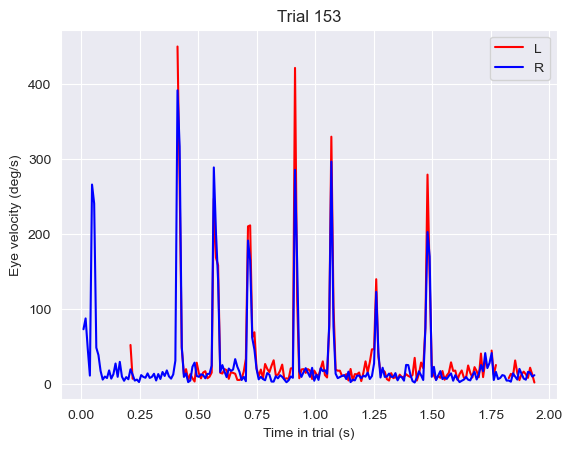

In [105]:
trial = 152
plt.figure()
plt.plot(np.cumsum(left_eye_trial_data.elapsed_time[trial][1:]), left_eye_trial_data.velocities[trial], 'r', label='L')
plt.plot(np.cumsum(right_eye_trial_data.elapsed_time[trial][1:]), right_eye_trial_data.velocities[trial], 'b', label='R')
plt.xlabel('Time in trial (s)')
plt.ylabel('Eye velocity (deg/s)')
plt.legend()
plt.title(f'Trial {trial+1}')

In [204]:
### Eye velocity across trial time plots for all trials
fig_dir = f'/Users/joseph/Documents/GitHub/figures/eye_trace/{db_name}/eye_velocities'
for trial in range(n_trials):
    plt.figure()
    plt.plot(np.cumsum(left_eye_trial_data.elapsed_time[trial][1:]), left_eye_trial_data.velocities[trial], 'r', label='L')
    plt.plot(np.cumsum(right_eye_trial_data.elapsed_time[trial][1:]), right_eye_trial_data.velocities[trial], 'b', label='R')
    plt.xlabel('Time in trial (s)')
    plt.ylabel('Eye velocity (deg/s)')
    plt.legend()
    plt.title(f'Trial {trial+1}')

    fig_name = f'trial{trial+1}_eye_velocity.png'
    if not os.path.exists(f'{fig_dir}/{fig_name}') or overwrite_files:
        if not os.path.exists(fig_dir):
            os.makedirs(fig_dir)
        plt.savefig(f'{fig_dir}/{fig_name}', bbox_inches='tight')
    plt.close()

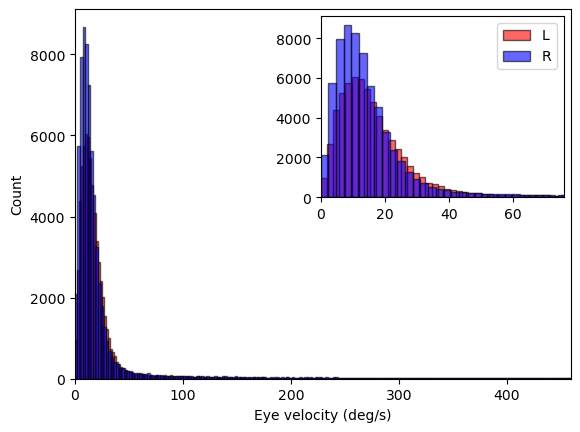

In [205]:
### Eye velocity distribution across all trials
plt.figure()
n_hist_bins = 500
plt.hist(np.concatenate(left_eye_trial_data.velocities), bins=n_hist_bins, color='r', edgecolor='k', alpha=0.6, label='L')
plt.hist(np.concatenate(right_eye_trial_data.velocities), bins=n_hist_bins, color='b', edgecolor='k', alpha=0.6, label='R')
plt.xlim([0, np.percentile(np.nan_to_num(np.concatenate([np.concatenate(left_eye_trial_data.velocities), np.concatenate(right_eye_trial_data.velocities)])), 99)])

# Create zoomed inset axes
ax = plt.gca()
axins = inset_axes(ax, width="70%", height="70%", loc="upper right", bbox_to_anchor=(0.3, 0.3, 0.7, 0.7), bbox_transform=ax.transAxes)
axins.hist(np.concatenate(left_eye_trial_data.velocities), bins=n_hist_bins, color='r', edgecolor='k', alpha=0.6, label='L')
axins.hist(np.concatenate(right_eye_trial_data.velocities), bins=n_hist_bins, color='b', edgecolor='k', alpha=0.6, label='R')
axins.set_xlim([0, np.percentile(np.nan_to_num(np.concatenate([np.concatenate(left_eye_trial_data.velocities), np.concatenate(right_eye_trial_data.velocities)])), 92.5)])

ax.set_xlabel('Eye velocity (deg/s)')
ax.set_ylabel('Count')
plt.legend()

fig_dir = f'/Users/joseph/Documents/GitHub/figures/eye_trace/{db_name}'
fig_name = f'eye_velocity_hist.png'
if not os.path.exists(f'{fig_dir}/{fig_name}') or overwrite_files:
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)
    plt.savefig(f'{fig_dir}/{fig_name}', bbox_inches='tight')

Visualize eye tracking data per trial

In [8]:
# I don't know how to deal with rectangles, so here are some functions that do things with rectangles
# rectangles represented as a 4-tuple of (x1, y1, x2, y2) i.e. x, y coords of top-left (1) and bottom-right (2) corners
def is_contained_rectangle(rect_inner, rect_outer):
    # check if **rect_inner** is completely contained within **rect_outer**
    x1_r1, y1_r1, x2_r1, y2_r1 = rect_inner
    x1_r2, y1_r2, x2_r2, y2_r2 = rect_outer
    return x1_r1 >= x1_r2 and y1_r1 >= y1_r2 and x2_r1 <= x2_r2 and y2_r1 <= y2_r2

def area_of_rectangle(rect):
    # self-explanatory
    x1, y1, x2, y2 = rect
    return abs((x2 - x1) * (y2 - y1))

def combined_area_of_rectangles(rect1, rect2):
    # sum of areas of **rect1** and **rect2**, accounting for possible overlap between the two
    x1_r1, y1_r1, x2_r1, y2_r1 = rect1
    x1_r2, y1_r2, x2_r2, y2_r2 = rect2
    if is_contained_rectangle(rect1 ,rect2):
        return area_of_rectangle(rect2)
    elif is_contained_rectangle(rect2, rect1):
        return area_of_rectangle(rect1)
    else:
        overlap_area = max(0, min(x2_r1, x2_r2) - max(x1_r1, x1_r2)) * max(0, min(y2_r1, y2_r2) - max(y1_r1, y1_r2))
        return area_of_rectangle(rect1) + area_of_rectangle(rect2) - overlap_area

# This one's for displaying p-values
def format_pval(pval):
    return '<0.001' if pval < 0.001 else f'{pval:.3f}'

('/Users/joseph/Documents/GitHub/OneMonkey/3941.JPG', 'w: 3368', 'h: 3944')

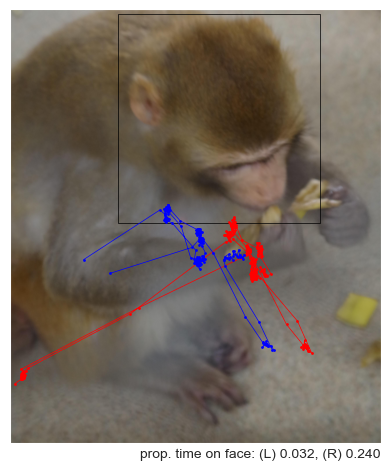

In [82]:
trial = 11
plt.figure()
ax = plt.gca()

# Read in image file
img_file = slide_trial_data.image_path[trial]
img = plt.imread(img_file)
img_height_pixel, img_width_pixel = img.shape[:2]

# Plot location of gaze trace
left_eye_trace = left_eye_trial_data.coordinates[trial].copy()
right_eye_trace = right_eye_trial_data.coordinates[trial].copy()
# Correct y-coordinates for origin being on the top left
left_eye_trace[:,1] = img_height_pixel - left_eye_trace[:,1]
right_eye_trace[:,1] = img_height_pixel - right_eye_trace[:,1]
# mean_eye_trace = (left_eye_trace + right_eye_trace) / 2
plt.plot(left_eye_trace[:,0], left_eye_trace[:,1], 'r-', linewidth=0.5, marker='.', markersize=2, label='L')
plt.plot(right_eye_trace[:,0], right_eye_trace[:,1], 'b-',  linewidth=0.5, marker='.', markersize=2, label='R')
# plt.plot(mean_eye_trace[:,0], mean_eye_trace[:,1], 'm.', markersize=2)

# Plot face bounding boxes for all monkeys in the image
monkey_id = int(img_file.split('/')[-1].split('.')[0])
body_coordinates = connection.get_column_from_table('body', 'photo_metadata.monkeysCoord', 'monkey_id', monkey_id, lambda x: eval(x) if x else None)
if body_coordinates is None:
    body_coordinates = (0, 0, img_width_pixel, img_height_pixel)
# Get other monkeys in the image (if there are multiple)
jpg_id = connection.get_column_from_table('jpg_id', 'photo_metadata.monkeys', 'monkey_id', monkey_id)
all_monkey_ids = connection.get_column_from_table('monkey_id', 'photo_metadata.monkeys', 'jpg_id', jpg_id)
if type(all_monkey_ids) != list:
    all_monkey_ids = [all_monkey_ids]
left_eye_trace_on_face, right_eye_trace_on_face = np.array([]), np.array([])
for m_id in all_monkey_ids:
    # Import pixel data for bounding boxes
    face_coordinates = connection.get_column_from_table('face', 'photo_metadata.monkeysCoord', 'monkey_id', m_id, lambda x: eval(x) if x else None)
    if face_coordinates is not None:
        # Plot face bounding box
        x1, y1 = face_coordinates[0] - body_coordinates[0], face_coordinates[1] - body_coordinates[1]
        x2, y2 = face_coordinates[2] - body_coordinates[0], face_coordinates[3] - body_coordinates[1]
        # Crop face bounding box to be within the image
        if not is_contained_rectangle(face_coordinates, body_coordinates):
            x1, y1 = min(img_width_pixel, max(0, x1)), min(img_height_pixel, max(0, y1))
            x2, y2 = min(img_width_pixel, max(0, x2)), min(img_height_pixel, max(0, x2))
        bounding_box_face = Rectangle((x1, y1), x2-x1, y2-y1, linewidth=0.5, edgecolor='k', facecolor='none')
        ax.add_patch(bounding_box_face)
        # Get data points that fall into face bounding box
        left_eye_trace_on_face = np.append(left_eye_trace_on_face,
                                 np.where((left_eye_trace[:,0] > x1) & (left_eye_trace[:,0] < x2) & (left_eye_trace[:,1] > y1) & (left_eye_trace[:,1] < y2)))
        right_eye_trace_on_face = np.append(right_eye_trace_on_face,
                                  np.where((right_eye_trace[:,0] > x1) & (right_eye_trace[:,0] < x2) & (right_eye_trace[:,1] > y1) & (right_eye_trace[:,1] < y2)))
left_eye_trace_on_face, right_eye_trace_on_face = np.unique(left_eye_trace_on_face), np.unique(right_eye_trace_on_face)

# Calculate proportion of time spent in face bounding box(es)
left_eye_proportion_on_face = left_eye_trace_on_face.shape[0] / left_eye_trace.shape[0]
right_eye_proportion_on_face = right_eye_trace_on_face.shape[0] / right_eye_trace.shape[0]
ax.text(1, -0.01, f'prop. time on face: (L) {left_eye_proportion_on_face:.3f}, (R) {right_eye_proportion_on_face:.3f}',
        ha='right', va='top', transform=ax.transAxes, fontsize=10)

plt.xticks([])
plt.yticks([])
plt.imshow(img)
# plt.legend()
# plt.title(f'monkey_id: {monkey_id}', fontsize=10)
plt.tight_layout()
img_file, f'w: {img_width_pixel}', f'h: {img_height_pixel}'

In [398]:
### Not plotting anything but just computing metrics
left_eye_proportion_on_face_all_trials, right_eye_proportion_on_face_all_trials = np.zeros(n_trials), np.zeros(n_trials)
mean_eye_proportion_on_face_all_trials = np.zeros(n_trials)
body_coordinates_all_trials, face_coordinates_all_trials = list(), list()

for trial in range(n_trials):
    # Read in image file
    img_file = slide_trial_data.image_path[trial]
    img = plt.imread(img_file)
    img_height_pixel, img_width_pixel = img.shape[:2]

    # Plot location of gaze trace
    left_eye_trace = left_eye_trial_data.coordinates[trial].copy()
    right_eye_trace = right_eye_trial_data.coordinates[trial].copy()
    # Correct for origin being on the top left
    left_eye_trace[:,1] = img_height_pixel - left_eye_trace[:,1]
    right_eye_trace[:,1] = img_height_pixel - right_eye_trace[:,1]
    mean_eye_trace = (left_eye_trace + right_eye_trace) / 2

    # Plot face bounding boxes for all monkeys in the image
    monkey_id = int(img_file.split('/')[-1].split('.')[0])
    body_coordinates = connection.get_column_from_table('body', 'photo_metadata.monkeysCoord', 'monkey_id', monkey_id, lambda x: eval(x) if x else None)
    if body_coordinates is None:
        body_coordinates = (0, 0, img_width_pixel, img_height_pixel)
    body_coordinates_all_trials.append((0, 0, img_width_pixel, img_height_pixel))
    # Get other monkeys in the image (if there are multiple)
    jpg_id = connection.get_column_from_table('jpg_id', 'photo_metadata.monkeys', 'monkey_id', monkey_id)
    all_monkey_ids = connection.get_column_from_table('monkey_id', 'photo_metadata.monkeys', 'jpg_id', jpg_id)
    if type(all_monkey_ids) != list:
        all_monkey_ids = [all_monkey_ids]
    left_eye_trace_on_face, right_eye_trace_on_face = np.array([]), np.array([])
    mean_eye_trace_on_face = np.array([])
    face_coordinates_all_monkeys = list()
    for m_id in all_monkey_ids:
        # Import pixel data for bounding boxes
        face_coordinates = connection.get_column_from_table('face', 'photo_metadata.monkeysCoord', 'monkey_id', m_id, lambda x: eval(x) if x else None)
        if face_coordinates is not None:
            # Plot face bounding box
            x1, y1 = face_coordinates[0] - body_coordinates[0], face_coordinates[1] - body_coordinates[1]
            x2, y2 = face_coordinates[2] - body_coordinates[0], face_coordinates[3] - body_coordinates[1]
            # Crop face bounding box to be within the image
            if not is_contained_rectangle(face_coordinates, body_coordinates):
                x1, y1 = min(img_width_pixel, max(0, x1)), min(img_height_pixel, max(0, y1))
                x2, y2 = min(img_width_pixel, max(0, x2)), min(img_height_pixel, max(0, x2))
            face_coordinates_all_monkeys.append((x1, y1, x2, y2))
            # Get data points that fall into face bounding box
            left_eye_trace_on_face = np.append(left_eye_trace_on_face,
                                     np.where((left_eye_trace[:,0] > x1) & (left_eye_trace[:,0] < x2) & (left_eye_trace[:,1] > y1) & (left_eye_trace[:,1] < y2)))
            right_eye_trace_on_face = np.append(right_eye_trace_on_face,
                                      np.where((right_eye_trace[:,0] > x1) & (right_eye_trace[:,0] < x2) & (right_eye_trace[:,1] > y1) & (right_eye_trace[:,1] < y2)))
            mean_eye_trace_on_face = np.append(mean_eye_trace_on_face,
                                      np.where((mean_eye_trace[:,0] > x1) & (mean_eye_trace[:,0] < x2) & (mean_eye_trace[:,1] > y1) & (mean_eye_trace[:,1] < y2)))
    left_eye_trace_on_face, right_eye_trace_on_face = np.unique(left_eye_trace_on_face), np.unique(right_eye_trace_on_face)
    mean_eye_trace_on_face = np.unique(mean_eye_trace_on_face)
    face_coordinates_all_trials.append(face_coordinates_all_monkeys)

    # Calculate proportion of time spent in face bounding box(es)
    left_eye_proportion_on_face = left_eye_trace_on_face.shape[0] / left_eye_trace.shape[0] if left_eye_trace.shape[0] != 0 else 0
    right_eye_proportion_on_face = right_eye_trace_on_face.shape[0] / right_eye_trace.shape[0] if right_eye_trace.shape[0] != 0 else 0
    mean_eye_proportion_on_face = mean_eye_trace_on_face.shape[0] / mean_eye_trace.shape[0] if right_eye_trace.shape[0] != 0 else 0
    left_eye_proportion_on_face_all_trials[trial] = left_eye_proportion_on_face
    right_eye_proportion_on_face_all_trials[trial] = right_eye_proportion_on_face
    mean_eye_proportion_on_face_all_trials[trial] = mean_eye_proportion_on_face

In [399]:
### Eye trace plots for all trials
fig_dir = f'/Users/joseph/Documents/GitHub/figures/eye_trace/{db_name}/individual_trials'
for trial in range(n_trials):
    plt.figure()
    ax = plt.gca()

    # Read in image file
    img_file = slide_trial_data.image_path[trial]
    img = plt.imread(img_file)
    img_height_pixel, img_width_pixel = img.shape[:2]

    # Plot location of gaze trace
    left_eye_trace = left_eye_trial_data.coordinates[trial].copy()
    right_eye_trace = right_eye_trial_data.coordinates[trial].copy()
    # Correct y-coordinates for origin being on the top left
    left_eye_trace[:,1] = img_height_pixel - left_eye_trace[:,1]
    right_eye_trace[:,1] = img_height_pixel - right_eye_trace[:,1]
    # mean_eye_trace = (left_eye_trace + right_eye_trace) / 2
    plt.plot(left_eye_trace[:,0], left_eye_trace[:,1], 'r.', markersize=2, label='L')
    plt.plot(right_eye_trace[:,0], right_eye_trace[:,1], 'b.', markersize=2, label='R')
    # plt.plot(mean_eye_trace[:,0], mean_eye_trace[:,1], 'm.', markersize=2)

    # Plot face bounding boxes for all monkeys in the image
    for face_coordinates in face_coordinates_all_trials[trial]:
        x1, y1, x2, y2 = face_coordinates
        bounding_box_face = Rectangle((x1, y1), x2-x1, y2-y1, linewidth=0.5, edgecolor='k', facecolor='none')
        ax.add_patch(bounding_box_face)

    # Calculate proportion of time spent in face bounding box(es)
    left_eye_proportion_on_face = left_eye_proportion_on_face_all_trials[trial]
    right_eye_proportion_on_face = right_eye_proportion_on_face_all_trials[trial]
    # mean_eye_proportion_on_face = mean_eye_proportion_on_face_all_trials[trial]
    ax.text(1, -0.01, f'prop. time on face: (L) {left_eye_proportion_on_face:.3f}, (R) {right_eye_proportion_on_face:.3f}',
            ha='right', va='top', transform=ax.transAxes, fontsize=10)

    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    # plt.legend()
    # plt.title(f'monkey_id: {monkey_id}', fontsize=10)
    plt.tight_layout()
    fig_name = f'trial{trial+1}_eye_trace.png'
    if not os.path.exists(f'{fig_dir}/{fig_name}') or overwrite_files:
        if not os.path.exists(fig_dir):
            os.makedirs(fig_dir)
        plt.savefig(f'{fig_dir}/{fig_name}', bbox_inches='tight')
    plt.close()

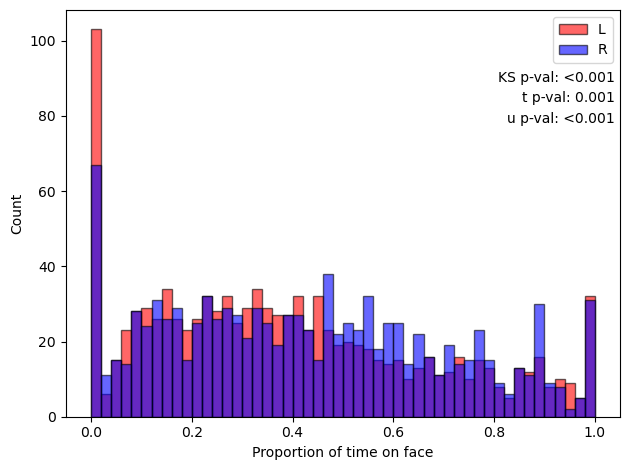

In [400]:
plt.figure()
ax = plt.gca()

plt.hist(left_eye_proportion_on_face_all_trials, bins=50, color='r', edgecolor='k', alpha=0.6, label='L')
plt.hist(right_eye_proportion_on_face_all_trials, bins=50, color='b', edgecolor='k', alpha=0.6, label='R')
ks_pval = stats.ks_2samp(left_eye_proportion_on_face_all_trials, right_eye_proportion_on_face_all_trials).pvalue
t_pval = stats.ttest_ind(left_eye_proportion_on_face_all_trials, right_eye_proportion_on_face_all_trials).pvalue
u_pval = stats.mannwhitneyu(left_eye_proportion_on_face_all_trials, right_eye_proportion_on_face_all_trials).pvalue
plt.text(0.99, 0.85, f'KS p-val: {format_pval(ks_pval)}', ha='right', va='top', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.99, 0.80, f't p-val: {format_pval(t_pval)}', ha='right', va='top', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.99, 0.75, f'u p-val: {format_pval(u_pval)}', ha='right', va='top', transform=plt.gca().transAxes, fontsize=10)

# plt.title(f'Proportion of time on face across all trials, {db_name}', fontsize=10)
plt.xlabel('Proportion of time on face')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()

fig_dir = f'/Users/joseph/Documents/GitHub/figures/eye_trace/{db_name}'
fig_name = 'left_vs_right_hist.png'
if not os.path.exists(f'{fig_dir}/{fig_name}') or overwrite_files:
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)
    plt.savefig(f'{fig_dir}/{fig_name}', bbox_inches='tight')

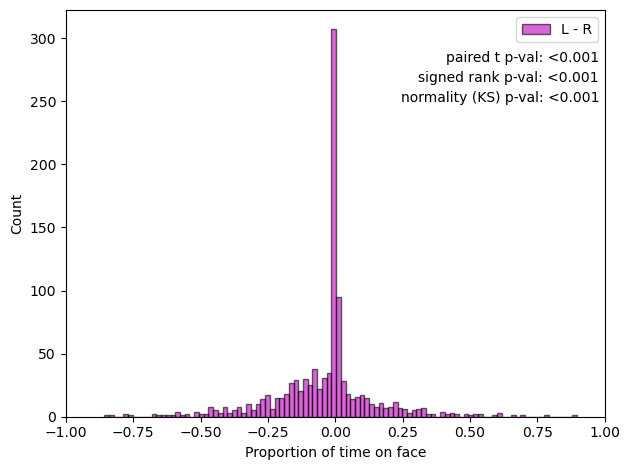

In [401]:
plt.figure()
ax = plt.gca()

plt.hist(left_eye_proportion_on_face_all_trials - right_eye_proportion_on_face_all_trials,
         bins=100, color='m', edgecolor='k', alpha=0.6, label='L - R')
paired_t_pval = stats.ttest_rel(left_eye_proportion_on_face_all_trials, right_eye_proportion_on_face_all_trials).pvalue
wilcoxon_pval = stats.wilcoxon(left_eye_proportion_on_face_all_trials, right_eye_proportion_on_face_all_trials).pvalue
ks_norm_pval = stats.kstest(left_eye_proportion_on_face_all_trials - right_eye_proportion_on_face_all_trials, 'norm').pvalue
plt.text(0.99, 0.9, f'paired t p-val: {format_pval(paired_t_pval)}', ha='right', va='top', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.99, 0.85, f'signed rank p-val: {format_pval(wilcoxon_pval)}', ha='right', va='top', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.99, 0.8, f'normality (KS) p-val: {format_pval(ks_norm_pval)}', ha='right', va='top', transform=plt.gca().transAxes, fontsize=10)

# plt.title(f'Proportion of time on face across all trials, {db_name}', fontsize=10)
plt.xlim([-1, 1])
plt.xlabel('Proportion of time on face')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()

fig_dir = f'/Users/joseph/Documents/GitHub/figures/eye_trace/{db_name}'
fig_name = 'left_vs_right_hist_v2.png'
if not os.path.exists(f'{fig_dir}/{fig_name}') or overwrite_files:
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)
    plt.savefig(f'{fig_dir}/{fig_name}', bbox_inches='tight')

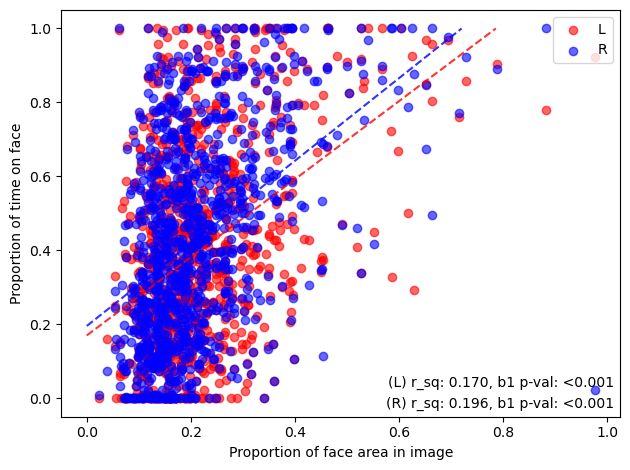

In [402]:
# Compute area of faces in image relative to total area of image
total_image_area_all_trials = np.array(list(map(area_of_rectangle, body_coordinates_all_trials)))
total_face_area_all_trials = np.zeros(n_trials)
for trial, face_coordinates_all_monkeys in enumerate(face_coordinates_all_trials):
    match len(face_coordinates_all_monkeys):
        case 0:
            face_area = 0
        case 1:
            face_area = area_of_rectangle(face_coordinates_all_monkeys[0])
        case _:
            face_area = functools.reduce(combined_area_of_rectangles, face_coordinates_all_monkeys)
    total_face_area_all_trials[trial] = face_area
face_area_proportion_all_trials = total_face_area_all_trials / total_image_area_all_trials

# Fit best fit line for face area in image against eye trace time on face (linear regression)
linreg_fit_left_eye = stats.linregress(face_area_proportion_all_trials, left_eye_proportion_on_face_all_trials)
linreg_fit_right_eye = stats.linregress(face_area_proportion_all_trials, right_eye_proportion_on_face_all_trials)
params_left_eye = (linreg_fit_left_eye.intercept, linreg_fit_left_eye.slope)  # params: (intercept, slope)
r2_left_eye, pval_left_eye = linreg_fit_left_eye.rvalue ** 2, linreg_fit_left_eye.pvalue
params_right_eye = (linreg_fit_right_eye.intercept, linreg_fit_right_eye.slope)  # params: (intercept, slope)
r2_right_eye, pval_right_eye = linreg_fit_right_eye.rvalue ** 2, linreg_fit_right_eye.pvalue

# Plot as scatter plot with best fit line
plt.figure()
ax = plt.gca()

plt.scatter(face_area_proportion_all_trials, left_eye_proportion_on_face_all_trials, color='r', alpha=0.6, label=f'L')
plt.scatter(face_area_proportion_all_trials, right_eye_proportion_on_face_all_trials, color='b', alpha=0.6, label=f'R')

best_fit_left_eye = (np.array([0, (1 - params_left_eye[0]) / params_left_eye[1]]), np.array([params_left_eye[0], 1]))
best_fit_right_eye = (np.array([0, (1 - params_right_eye[0]) / params_right_eye[1]]), np.array([params_right_eye[0], 1]))
plt.plot(best_fit_left_eye[0], best_fit_left_eye[1], 'r--', alpha=0.8)
plt.plot(best_fit_right_eye[0], best_fit_right_eye[1], 'b--', alpha=0.8)
plt.text(0.99, 0.1, f'(L) r_sq: {r2_left_eye:.3f}, b1 p-val: {format_pval(pval_left_eye)}', ha='right', va='top', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.99, 0.05, f'(R) r_sq: {r2_right_eye:.3f}, b1 p-val: {format_pval(pval_right_eye)}', ha='right', va='top', transform=plt.gca().transAxes, fontsize=10)

# plt.title(f'Proportion of time on face across all trials, {db_name}', fontsize=10)
plt.xlabel('Proportion of face area in image')
plt.ylabel('Proportion of time on face')
plt.legend(loc='upper right')
plt.tight_layout()

fig_dir = f'/Users/joseph/Documents/GitHub/figures/eye_trace/{db_name}'
fig_name = 'face_area_vs_time_on_face_scatter.png'
if not os.path.exists(f'{fig_dir}/{fig_name}') or overwrite_files:
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)
    plt.savefig(f'{fig_dir}/{fig_name}', bbox_inches='tight')

Visualize eye tracking data per monkey subject

In [185]:
# Names of monkeys that are part of the Zombies group
zombies_monkey_names = {'7124', '69X', '72X', '94B', '110E', '67G', '143H', '87J', '151J'}
zombies_monkey_names_ordered = ['7124', '69X', '72X', '94B', '110E', '67G', '143H', '87J', '151J']

In [167]:
# Get all trial numbers in which each monkey appears
# For both manual and automatic curation of full face images
monkey_name_per_trial = list()
trials_per_monkey_name = {monkey_name: list() for monkey_name in zombies_monkey_names_ordered}
for trial in range(n_trials):
    img_file = slide_trial_data.image_path[trial]
    monkey_id = int(img_file.split('/')[-1].split('.')[0])
    monkey_name = connection.get_column_from_table('monkey_name', 'photo_metadata.monkeys', 'monkey_id', monkey_id, str)
    monkey_name_per_trial.append(monkey_name)
    if monkey_name in zombies_monkey_names:
        trials_per_monkey_name[monkey_name].append(trial)
monkey_name_per_trial = np.array(monkey_name_per_trial)
trials_per_monkey_name = {monkey_name: np.array(trial_list) for monkey_name, trial_list in trials_per_monkey_name.items()}

In [168]:
# Pick out full face trials from whitelist
# For automatic curation of full face images
with open('full_face_image_list.pkl', 'rb') as file:
    full_face_images_per_monkey, seen_images_per_monkey = pickle.load(file)

full_face_trials_per_monkey = {monkey: list() for monkey in zombies_monkey_names_ordered}
new_image_trials_per_monkey = {monkey: list() for monkey in zombies_monkey_names_ordered}
curation_warning_flag = False
for monkey, trials in trials_per_monkey_name.items():
    monkey_id_list = list(map(lambda img_file: int(img_file.split('/')[-1].split('.')[0]), slide_trial_data.image_path[trials]))
    if monkey not in seen_images_per_monkey:
        # If this monkey has never been included before in the dataset
        trial_filter = [i for i, monkey_id in enumerate(monkey_id_list)]
        new_image_trials_per_monkey[monkey] = trials[trial_filter]
        full_face_trials_per_monkey[monkey] = trials[trial_filter]
        curation_warning_flag = True
        continue
    if not set(monkey_id_list) <= seen_images_per_monkey[monkey]:
        # Keep track of trials which have images that have not been seen before during manual curation
        trial_filter = [i for i, monkey_id in enumerate(monkey_id_list) if monkey_id not in seen_images_per_monkey[monkey]]
        new_image_trials_per_monkey[monkey] = trials[trial_filter]
        curation_warning_flag = True
    trial_filter = [i for i, monkey_id in enumerate(monkey_id_list) if monkey_id in full_face_images_per_monkey[monkey]]
    full_face_trials_per_monkey[monkey] = trials[trial_filter]
if curation_warning_flag:
    print('Some images may not have been inspected before, recommended to run manual curation on this dataset')
else:
    del new_image_trials_per_monkey

Some images may not have been inspected before, recommended to run manual curation on this dataset


In [169]:
# Read in filtered list of trials from excel (.xlsx) file
# Run after manual curation of full face images
full_face_trials_per_monkey = pd.read_excel('Connor Monkey Groups 06202022.xlsx', sheet_name=db_name)
full_face_trials_per_monkey = {str(col): full_face_trials_per_monkey[col].to_numpy() for col in full_face_trials_per_monkey.columns\
                               if str(col) in zombies_monkey_names}
full_face_trials_per_monkey = {key: val[~np.isnan(val)].astype(int) for key, val in full_face_trials_per_monkey.items()}

In [170]:
# Add to whitelist of full face images for each monkey
# To cache results of manual curation
if os.path.exists('full_face_image_list.pkl'):
    with open('full_face_image_list.pkl', 'rb') as file:
        full_face_images_per_monkey, seen_images_per_monkey = pickle.load(file)
else:
    full_face_images_per_monkey = {monkey: set() for monkey in zombies_monkey_names_ordered}
    seen_images_per_monkey = {monkey: set() for monkey in zombies_monkey_names_ordered}

for monkey, trials in full_face_trials_per_monkey.items():
    image_list = set(map(lambda img_file: int(img_file.split('/')[-1].split('.')[0]), slide_trial_data.image_path[trials]))
    if monkey not in full_face_images_per_monkey:
        full_face_images_per_monkey[monkey] = set()
    full_face_images_per_monkey[monkey].update(image_list)
for monkey, trials in trials_per_monkey_name.items():
    image_list = set(map(lambda img_file: int(img_file.split('/')[-1].split('.')[0]), slide_trial_data.image_path[trials]))
    if monkey not in seen_images_per_monkey:
        seen_images_per_monkey[monkey] = set()
    seen_images_per_monkey[monkey].update(image_list)

if overwrite_files:
    with open('full_face_image_list.pkl', 'wb') as file:
        pickle.dump((full_face_images_per_monkey, seen_images_per_monkey), file)

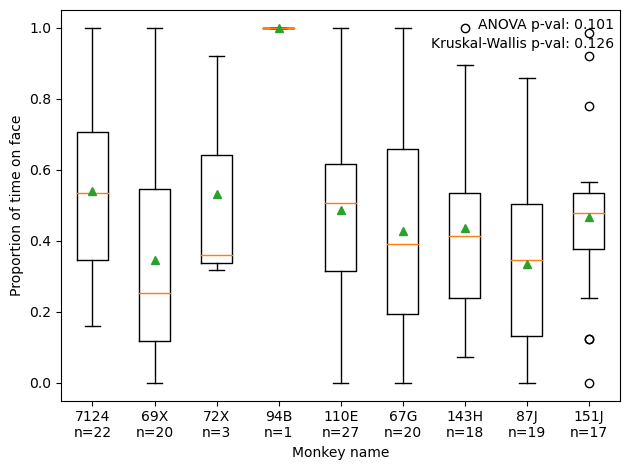

In [171]:
plt.figure()
ax = plt.gca()

mean_eye_proportion_on_face_per_monkey_all_trials = {key: mean_eye_proportion_on_face_all_trials[val] for key, val in full_face_trials_per_monkey.items()}
plt.boxplot(mean_eye_proportion_on_face_per_monkey_all_trials.values(), positions=range(len(mean_eye_proportion_on_face_per_monkey_all_trials)),
            vert=True, showmeans=True)

# Run ANOVA to test if there are any significant differences across monkeys
_, anova_pval = stats.f_oneway(*mean_eye_proportion_on_face_per_monkey_all_trials.values())
_, kruskal_pval = stats.kruskal(*mean_eye_proportion_on_face_per_monkey_all_trials.values())
plt.text(0.99, 0.98, f'ANOVA p-val: {format_pval(anova_pval)}', ha='right', va='top', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.99, 0.93, f'Kruskal-Wallis p-val: {format_pval(kruskal_pval)}', ha='right', va='top', transform=plt.gca().transAxes, fontsize=10)

# plt.title(f'Proportion of time on face across all trials, {db_name}', fontsize=10)
plt.xlabel('Monkey name')
plt.ylabel('Proportion of time on face')
# plt.xticks(range(len(mean_eye_proportion_on_face_monkey_trials)), labels=mean_eye_proportion_on_face_monkey_trials.keys())
plt.xticks(range(len(mean_eye_proportion_on_face_per_monkey_all_trials)),
           labels=[f'{key}\nn={val.shape[0]}' for key, val in mean_eye_proportion_on_face_per_monkey_all_trials.items()])
plt.tight_layout()

fig_dir = f'/Users/joseph/Documents/GitHub/figures/eye_trace/{db_name}'
fig_name = 'time_on_face_across_monkeys_boxplot.png'
if not os.path.exists(f'{fig_dir}/{fig_name}') or overwrite_files:
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)
    plt.savefig(f'{fig_dir}/{fig_name}', bbox_inches='tight')

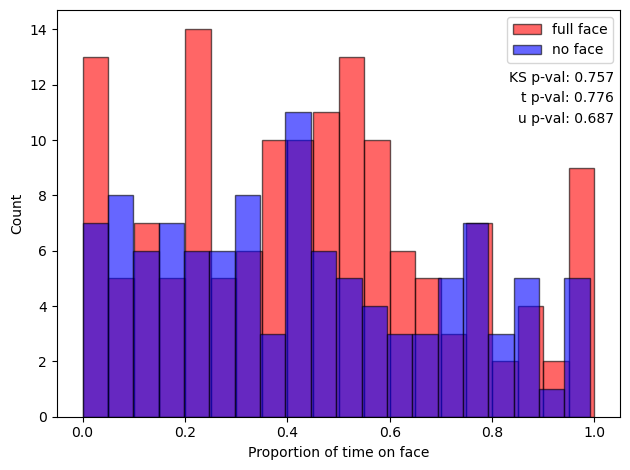

In [172]:
# Compare across all monkeys, full-face vs no face
full_face_trials_all_zombies = functools.reduce(lambda x, y: np.concatenate((x, y)), full_face_trials_per_monkey.values())
no_face_trials_all_zombies = functools.reduce(lambda x, y: np.concatenate((x, y)), trials_per_monkey_name.values())
no_face_trials_all_zombies = no_face_trials_all_zombies[~np.isin(no_face_trials_all_zombies, full_face_trials_all_zombies)]

mean_eye_proportion_on_face_full_face_zombies = mean_eye_proportion_on_face_all_trials[full_face_trials_all_zombies]
mean_eye_proportion_on_face_no_face_zombies = mean_eye_proportion_on_face_all_trials[no_face_trials_all_zombies]

# Plot as histograms
plt.figure()
ax = plt.gca()
n_hist_bins = 20

plt.hist(mean_eye_proportion_on_face_full_face_zombies, bins=n_hist_bins, color='r', edgecolor='k', alpha=0.6, label='full face')
plt.hist(mean_eye_proportion_on_face_no_face_zombies, bins=n_hist_bins, color='b', edgecolor='k', alpha=0.6, label='no face')
ks_pval = stats.ks_2samp(mean_eye_proportion_on_face_full_face_zombies, mean_eye_proportion_on_face_no_face_zombies).pvalue
t_pval = stats.ttest_ind(mean_eye_proportion_on_face_full_face_zombies, mean_eye_proportion_on_face_no_face_zombies).pvalue
u_pval = stats.mannwhitneyu(mean_eye_proportion_on_face_full_face_zombies, mean_eye_proportion_on_face_no_face_zombies).pvalue
plt.text(0.99, 0.85, f'KS p-val: {format_pval(ks_pval)}', ha='right', va='top', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.99, 0.80, f't p-val: {format_pval(t_pval)}', ha='right', va='top', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.99, 0.75, f'u p-val: {format_pval(u_pval)}', ha='right', va='top', transform=plt.gca().transAxes, fontsize=10)

# plt.title(f'Proportion of time on face across all trials, {db_name}', fontsize=10)
plt.xlabel('Proportion of time on face')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()

fig_dir = f'/Users/joseph/Documents/GitHub/figures/eye_trace/{db_name}'
fig_name = 'full_face_vs_no_face_hist.png'
if not os.path.exists(f'{fig_dir}/{fig_name}') or overwrite_files:
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)
    plt.savefig(f'{fig_dir}/{fig_name}', bbox_inches='tight')

Save processed data to pickle

In [173]:
file_dir = f'/Users/joseph/Documents/GitHub/data/eye_trace'
if not os.path.exists(file_dir):
    os.makedirs(file_dir)
with open(f'{file_dir}/{db_name}.pkl', 'wb') as file:
    pickle.dump((left_eye_trial_data, right_eye_trial_data, slide_trial_data, left_eye_proportion_on_face_all_trials, right_eye_proportion_on_face_all_trials,
                 mean_eye_proportion_on_face_all_trials, face_area_proportion_all_trials, mean_eye_proportion_on_face_per_monkey_all_trials,
                 mean_eye_proportion_on_face_full_face_zombies, mean_eye_proportion_on_face_no_face_zombies), file)

Face dwell time per monkey, across all days

In [313]:
# Generate list of .pkl files
file_dir = f'/Users/joseph/Documents/GitHub/data/eye_trace'
file_list_name = f'/Users/joseph/Documents/GitHub/data/eye_trace_file_list.txt'
if not os.path.exists(file_list_name):
    os.system(f'ls {file_dir} > {file_list_name}')

# Read in list of .pkl files and import
with open(file_list_name, 'r') as file:
    file_list = [line.strip() for line in file]

all_days_data = dict()
for pkl_file in file_list:
    db_name = pkl_file.split('.')[0]
    with open(f'{file_dir}/{pkl_file}', 'rb') as file:
        # Format of pkl file (with indices):
        # [0] left_eye_trial_data, [1] right_eye_trial_data, [2] slide_trial_data,
        # [3] left_eye_proportion_on_face_all_trials, [4] right_eye_proportion_on_face_all_trials, [5] mean_eye_proportion_on_face_all_trials, [6] face_area_proportion_all_trials,
        # [7] mean_eye_proportion_on_face_per_monkey_all_trials, [8] mean_eye_proportion_on_face_full_face_zombies, [9] mean_eye_proportion_on_face_no_face_zombies
        all_days_data[db_name] = pickle.load(file)

In [183]:
# Concatenate data across all recording days
mean_eye_proportion_on_face_all_trials_all_days = np.array([])
face_area_proportion_all_trials_all_days = np.array([])
mean_eye_proportion_on_face_per_monkey_all_trials_all_days = {monkey: np.array([]) for monkey in zombies_monkey_names_ordered}
mean_eye_proportion_on_face_full_face_zombies_all_days = np.array([])
mean_eye_proportion_on_face_no_face_zombies_all_days = np.array([])

for db_name, days_data in all_days_data.items():
    mean_eye_proportion_on_face_all_trials, face_area_proportion_all_trials,\
    mean_eye_proportion_on_face_per_monkey_all_trials, mean_eye_proportion_on_face_full_face_zombies, mean_eye_proportion_on_face_no_face_zombies = days_data[5:]
    # For scatter/line plot of face area in image against time on face
    mean_eye_proportion_on_face_all_trials_all_days = np.concatenate([mean_eye_proportion_on_face_all_trials_all_days, mean_eye_proportion_on_face_all_trials])
    face_area_proportion_all_trials_all_days = np.concatenate([face_area_proportion_all_trials_all_days, face_area_proportion_all_trials])
    # For boxplot of time on face per monkey & histogram of time on face for full face vs no face
    for key, val in mean_eye_proportion_on_face_per_monkey_all_trials_all_days.items():
        mean_eye_proportion_on_face_per_monkey_all_trials_all_days[key] = np.concatenate([val, mean_eye_proportion_on_face_per_monkey_all_trials[key]])
    mean_eye_proportion_on_face_full_face_zombies_all_days = np.concatenate([mean_eye_proportion_on_face_full_face_zombies_all_days, mean_eye_proportion_on_face_full_face_zombies])
    mean_eye_proportion_on_face_no_face_zombies_all_days = np.concatenate([mean_eye_proportion_on_face_no_face_zombies_all_days, mean_eye_proportion_on_face_no_face_zombies])

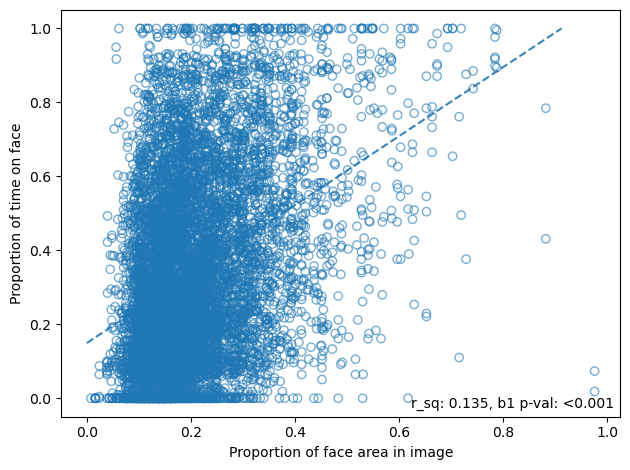

In [197]:
# Fit best fit line for face area in image against eye trace time on face (linear regression)
linreg_fit = stats.linregress(face_area_proportion_all_trials_all_days, mean_eye_proportion_on_face_all_trials_all_days)
linreg_params = (linreg_fit.intercept, linreg_fit.slope)  # params: (intercept, slope)
best_fit_line = (np.array([0, (1 - linreg_params[0]) / linreg_params[1]]), np.array([linreg_params[0], 1]))
linreg_r2, slope_pval = linreg_fit.rvalue ** 2, linreg_fit.pvalue

# Scatter plot with best fit line of face area in image against time on face
plt.figure()
ax = plt.gca()

plt.scatter(face_area_proportion_all_trials_all_days, mean_eye_proportion_on_face_all_trials_all_days, facecolors='none', edgecolors='C0', alpha=0.6)
plt.plot(best_fit_line[0], best_fit_line[1], linestyle='--', alpha=0.9)
plt.text(0.99, 0.05, f'r_sq: {linreg_r2:.3f}, b1 p-val: {format_pval(slope_pval)}', ha='right', va='top', transform=plt.gca().transAxes, fontsize=10)

# plt.title(f'Proportion of time on face across all trials, {db_name}', fontsize=10)
plt.xlabel('Proportion of face area in image')
plt.ylabel('Proportion of time on face')
# plt.legend(loc='upper right')
plt.tight_layout()

fig_dir = f'/Users/joseph/Documents/GitHub/figures/eye_trace'
fig_name = 'face_area_vs_time_on_face_scatter.png'
if not os.path.exists(f'{fig_dir}/{fig_name}') or overwrite_files:
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)
    plt.savefig(f'{fig_dir}/{fig_name}', bbox_inches='tight')

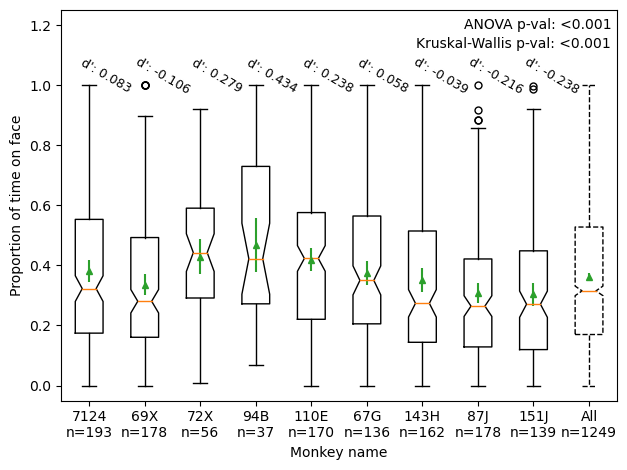

In [233]:
# Boxplots of time on face per monkey
plt.figure()
ax = plt.gca()

plt.boxplot(mean_eye_proportion_on_face_per_monkey_all_trials_all_days.values(), positions=range(len(mean_eye_proportion_on_face_per_monkey_all_trials_all_days)),
            vert=True, showmeans=True, notch=True,
            flierprops=dict(marker='o', markersize=5),
            meanprops=dict(marker='^', markersize=5))
plt.boxplot(mean_eye_proportion_on_face_full_face_zombies_all_days, widths=[0.5], positions=[len(mean_eye_proportion_on_face_per_monkey_all_trials_all_days)],
            vert=True, showmeans=True, notch=True,
            boxprops=dict(color='black', linestyle='dashed', linewidth=1),
            capprops=dict(color='black', linestyle='dashed', linewidth=1),
            whiskerprops=dict(color='black', linestyle='dashed', linewidth=1),
            flierprops=dict(marker='o', markersize=5),
            meanprops=dict(marker='^', markersize=5))

# Run ANOVA to test if there are any significant differences across monkeys
_, anova_pval = stats.f_oneway(*mean_eye_proportion_on_face_per_monkey_all_trials_all_days.values())
_, kruskal_pval = stats.kruskal(*mean_eye_proportion_on_face_per_monkey_all_trials_all_days.values())
plt.text(0.99, 0.98, f'ANOVA p-val: {format_pval(anova_pval)}', ha='right', va='top', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.99, 0.93, f'Kruskal-Wallis p-val: {format_pval(kruskal_pval)}', ha='right', va='top', transform=plt.gca().transAxes, fontsize=10)

# Compute effect sizes between time on face for each monkey and across all monkeys
def t_confidence_interval(x: np.ndarray, alpha: float=0.05) -> tuple[float, float]:
    # x should be a 1-d numpy array of the data, alpha is (1 - confidence) i.e. 0.05 for 95% confidence interval
    n, xbar, s = x.shape[0], np.mean(x), np.std(x, ddof=1)
    t_stat = stats.t.ppf(1 - alpha/2, n-1)
    return xbar - t_stat * s / np.sqrt(n), xbar + t_stat * s / np.sqrt(n)

def cohen_d(x1: np.ndarray, x2: np.ndarray) -> float:
    # x1 and x2 should be 1-d numpy arrays of the data
    n1, xbar1, s1 = x1.shape[0], np.mean(x1), np.std(x1, ddof=1)
    n2, xbar2, s2 = x2.shape[0], np.mean(x2), np.std(x2, ddof=1)
    s_pooled = np.sqrt(((n1-1) * s1**2 + (n2-1) * s2**2) / (n1 + n2 -2))
    return (xbar1 - xbar2) / s_pooled

mean_eye_proportion_on_face_per_monkey_conf_intervals_all_days = {key: t_confidence_interval(val) \
                                                                for key, val in mean_eye_proportion_on_face_per_monkey_all_trials_all_days.items()}
mean_eye_proportion_on_face_per_monkey_effect_sizes_all_days = {key: cohen_d(val, mean_eye_proportion_on_face_full_face_zombies_all_days) \
                                                                for key, val in mean_eye_proportion_on_face_per_monkey_all_trials_all_days.items()}
for i, (key, val) in enumerate(mean_eye_proportion_on_face_per_monkey_conf_intervals_all_days.items()):
    plt.vlines(x=i, ymin=val[0], ymax=val[1], colors='C2')
plt.vlines(x=len(mean_eye_proportion_on_face_per_monkey_all_trials_all_days),
           ymin=t_confidence_interval(mean_eye_proportion_on_face_full_face_zombies_all_days)[0],
           ymax=t_confidence_interval(mean_eye_proportion_on_face_full_face_zombies_all_days)[1],
           colors='C2')
for i, (key, val) in enumerate(mean_eye_proportion_on_face_per_monkey_effect_sizes_all_days.items()):
    plt.text(i-0.2, 1.03, f'd\': {val:.3f}', ha='left', va='center', rotation=-30, fontsize=9)

# plt.title(f'Proportion of time on face across all trials, {db_name}', fontsize=10)
plt.xlabel('Monkey name')
plt.ylabel('Proportion of time on face')
plt.ylim([-0.05, 1.25])
plt.xticks(range(len(mean_eye_proportion_on_face_per_monkey_all_trials_all_days)+1),
           labels=[f'{key}\nn={val.shape[0]}' for key, val in mean_eye_proportion_on_face_per_monkey_all_trials_all_days.items()] +\
                  [f'All\nn={mean_eye_proportion_on_face_full_face_zombies_all_days.shape[0]}'])
plt.tight_layout()

fig_dir = f'/Users/joseph/Documents/GitHub/figures/eye_trace'
fig_name = 'time_on_face_across_monkeys_boxplot.png'
if not os.path.exists(f'{fig_dir}/{fig_name}') or overwrite_files:
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)
    plt.savefig(f'{fig_dir}/{fig_name}', bbox_inches='tight')

In [334]:
# Permutation test for significance of time on face
def random_partition(arr, sizes):
    return np.split(np.random.permutation(arr), np.cumsum(sizes)[:-1])

n_trials_per_monkey = np.array([val.shape[0] for val in mean_eye_proportion_on_face_per_monkey_all_trials_all_days.values()])
n_repeats = 10_000
metric_fn = np.mean
metric_proportion_time_on_face_actual = {monkey: metric_fn(mean_eye_proportion_on_face_per_monkey_all_trials_all_days[monkey]) for monkey in zombies_monkey_names_ordered}
metric_proportion_time_on_face_shuffle_distribution = {monkey: np.zeros(n_repeats) for monkey in zombies_monkey_names_ordered}

for i in range(n_repeats):
    mean_eye_proportion_on_face_per_monkey_all_trials_shuffled = dict(zip(zombies_monkey_names_ordered, random_partition(mean_eye_proportion_on_face_full_face_zombies_all_days, n_trials_per_monkey)))
    for key, val in metric_proportion_time_on_face_shuffle_distribution.items():
        val[i] = metric_fn(mean_eye_proportion_on_face_per_monkey_all_trials_shuffled[key])
        metric_proportion_time_on_face_shuffle_distribution[key] = val

monkeys_of_interest = ['72X', '94B', '110E']
metric_proportion_time_on_face_actual['72X + 94B + 110E'] = functools.reduce(lambda x, y: x + y,
                                                            [n_trials_per_monkey[zombies_monkey_names_ordered.index(monkey)] * metric_proportion_time_on_face_actual[monkey] for monkey in monkeys_of_interest]) \
                                                          / functools.reduce(lambda x, y: x + y, [n_trials_per_monkey[zombies_monkey_names_ordered.index(monkey)] for monkey in monkeys_of_interest])
metric_proportion_time_on_face_shuffle_distribution['72X + 94B + 110E'] = functools.reduce(lambda x, y: x + y,
                                                                          [n_trials_per_monkey[zombies_monkey_names_ordered.index(monkey)] * metric_proportion_time_on_face_shuffle_distribution[monkey] for monkey in monkeys_of_interest]) \
                                                                        / functools.reduce(lambda x, y: x + y, [n_trials_per_monkey[zombies_monkey_names_ordered.index(monkey)] for monkey in monkeys_of_interest])

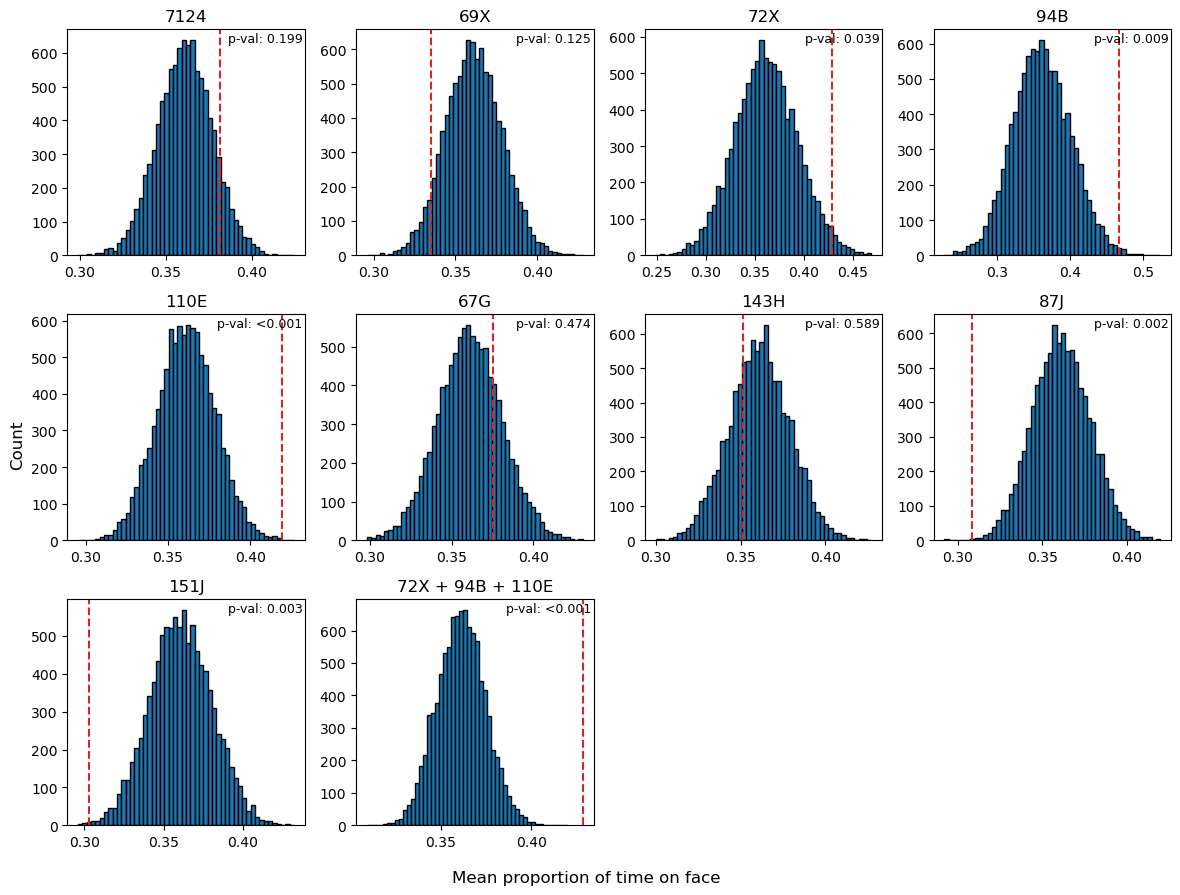

In [353]:
# Histogram of distribution of values from permutation test
def get_subplot_dims(n):
    rows = np.floor(np.sqrt(n)).astype(int)
    cols = np.ceil(n / rows).astype(int)
    return rows, cols

n_rows, n_cols = get_subplot_dims(len(metric_proportion_time_on_face_shuffle_distribution))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 9))
n_hist_bins = 50

for i, (monkey, distribution) in enumerate(metric_proportion_time_on_face_shuffle_distribution.items()):
    ax = axes[i//n_cols, i%n_cols]
    ax.hist(distribution, bins=n_hist_bins, edgecolor='k')
    actl_val = metric_proportion_time_on_face_actual[monkey]
    perc_val = stats.percentileofscore(distribution, actl_val, kind='rank') / 100
    perm_pval = 2 * min(perc_val, 1 - perc_val)  # for 2-tailed test
    ax.axvline(x=actl_val, color='C3', linestyle='--')
    ax.text(0.99, 0.99, f'p-val: {format_pval(perm_pval)}', ha='right', va='top', transform=ax.transAxes, fontsize=9)
    ax.set_title(monkey)
# Hide unused axes
for i in range(len(metric_proportion_time_on_face_shuffle_distribution), n_rows * n_cols):
    fig.delaxes(axes[i//n_cols, i%n_cols])

fig.supxlabel('Mean proportion of time on face')
fig.supylabel('Count')
plt.tight_layout()

fig_dir = f'/Users/joseph/Documents/GitHub/figures/eye_trace'
fig_name = 'time_on_face_across_monkeys_permutation_test.png'
if not os.path.exists(f'{fig_dir}/{fig_name}') or overwrite_files:
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)
    plt.savefig(f'{fig_dir}/{fig_name}', bbox_inches='tight')

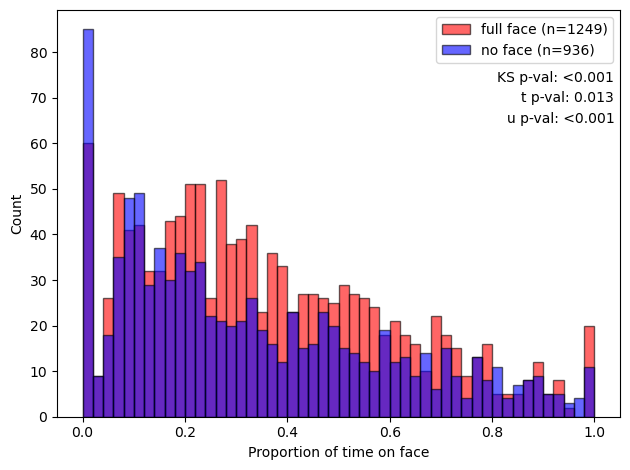

In [178]:
# Histogram of time on face for full face vs no face
plt.figure()
ax = plt.gca()
n_hist_bins = 50

n_full_face = mean_eye_proportion_on_face_full_face_zombies_all_days.shape[0]
plt.hist(mean_eye_proportion_on_face_full_face_zombies_all_days, bins=n_hist_bins, color='r', edgecolor='k', alpha=0.6, label=f'full face (n={n_full_face})')
n_no_face = mean_eye_proportion_on_face_no_face_zombies_all_days.shape[0]
plt.hist(mean_eye_proportion_on_face_no_face_zombies_all_days, bins=n_hist_bins, color='b', edgecolor='k', alpha=0.6, label=f'no face (n={n_no_face})')
ks_test = stats.ks_2samp(mean_eye_proportion_on_face_full_face_zombies_all_days, mean_eye_proportion_on_face_no_face_zombies_all_days)
ks_stat, ks_pval = ks_test.statistic, ks_test.pvalue
t_test = stats.ttest_ind(mean_eye_proportion_on_face_full_face_zombies_all_days, mean_eye_proportion_on_face_no_face_zombies_all_days)
t_stat, t_pval = t_test.statistic, t_test.pvalue
u_test = stats.mannwhitneyu(mean_eye_proportion_on_face_full_face_zombies_all_days, mean_eye_proportion_on_face_no_face_zombies_all_days)
u_stat, u_pval = u_test.statistic, u_test.pvalue
plt.text(0.99, 0.85, f'KS p-val: {format_pval(ks_pval)}', ha='right', va='top', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.99, 0.80, f't p-val: {format_pval(t_pval)}', ha='right', va='top', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.99, 0.75, f'u p-val: {format_pval(u_pval)}', ha='right', va='top', transform=plt.gca().transAxes, fontsize=10)

# plt.title(f'Proportion of time on face across all trials, {db_name}', fontsize=10)
plt.xlabel('Proportion of time on face')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()

fig_dir = f'/Users/joseph/Documents/GitHub/figures/eye_trace'
fig_name = 'full_face_vs_no_face_hist.png'
if not os.path.exists(f'{fig_dir}/{fig_name}') or overwrite_files:
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)
    plt.savefig(f'{fig_dir}/{fig_name}', bbox_inches='tight')

In [208]:
# Control for differences in sample size in histogram plot
n_repeats = 1000
# perm_test arrays: n_repeats x [stat, pval]
ks_bootstrap_test = np.zeros((n_repeats, 2))
t_bootstrap_test = np.zeros((n_repeats, 2))
u_bootstrap_test = np.zeros((n_repeats, 2))
for i in range(n_repeats):
    # Random subset of full face distribution to match sample size of no face distribution
    mean_eye_proportion_on_face_full_face_zombies_all_days_subset = mean_eye_proportion_on_face_full_face_zombies_all_days[np.random.choice(n_full_face, n_no_face)]
    ks_test = stats.ks_2samp(mean_eye_proportion_on_face_full_face_zombies_all_days_subset, mean_eye_proportion_on_face_no_face_zombies_all_days)
    ks_bootstrap_test[i] = [ks_test.statistic, ks_test.pvalue]
    t_test = stats.ttest_ind(mean_eye_proportion_on_face_full_face_zombies_all_days_subset, mean_eye_proportion_on_face_no_face_zombies_all_days)
    t_bootstrap_test[i] = [t_test.statistic, t_test.pvalue]
    u_test = stats.mannwhitneyu(mean_eye_proportion_on_face_full_face_zombies_all_days_subset, mean_eye_proportion_on_face_no_face_zombies_all_days)
    u_bootstrap_test[i] = [u_test.statistic, u_test.pvalue]

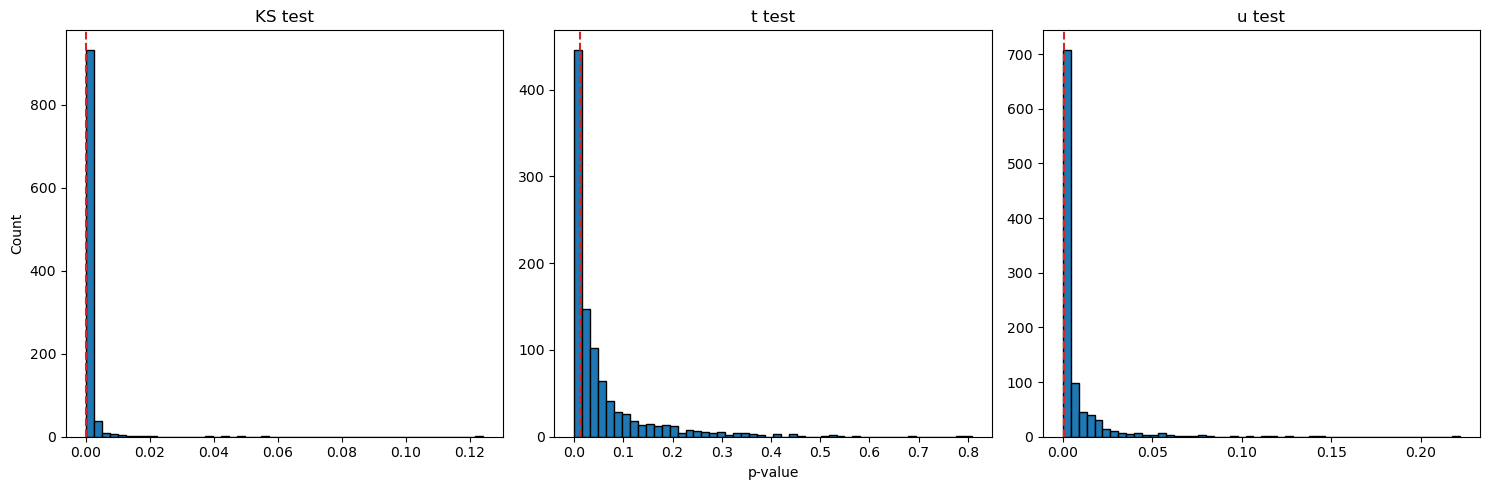

In [231]:
# Histogram of test statistics for bootstrapping test
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
n_hist_bins = 50

# KS test statistic
axes[0].hist(ks_bootstrap_test[:,1], bins=n_hist_bins, edgecolor='k')
axes[0].axvline(x=ks_pval, color='C3', linestyle='--')
axes[0].set_ylabel('Count')
axes[0].set_title('KS test')

# t test statistic
axes[1].hist(t_bootstrap_test[:,1], bins=n_hist_bins, edgecolor='k')
axes[1].axvline(x=t_pval, color='C3', linestyle='--')
axes[1].set_xlabel('p-value')
axes[1].set_title('t test')

# u test statistic
axes[2].hist(u_bootstrap_test[:,1], bins=n_hist_bins, edgecolor='k')
axes[2].axvline(x=u_pval, color='C3', linestyle='--')
axes[2].set_title('u test')

plt.tight_layout()
fig_dir = f'/Users/joseph/Documents/GitHub/figures/eye_trace'
fig_name = 'full_face_vs_no_face_bootstrapping.png'
if not os.path.exists(f'{fig_dir}/{fig_name}') or overwrite_files:
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)
    plt.savefig(f'{fig_dir}/{fig_name}', bbox_inches='tight')

In [372]:
# Concatenate eye velocity data for all trials across all days
left_eye_velocities_all_trials_all_days, left_eye_elapsed_time_all_trials_all_days = list(), list()
right_eye_velocities_all_trials_all_days, right_eye_elapsed_time_all_trials_all_days = list(), list()
n_trials_per_day = dict()

for db_name, days_data in all_days_data.items():
    left_eye_trial_data, right_eye_trial_data = days_data[:2]
    # Keep track of number of trials per recording session
    n_trials_per_day[db_name] = len(left_eye_trial_data.time)
    # Keep as list of eye velocity arrays per trial
    left_eye_velocities_all_trials_all_days.extend(left_eye_trial_data.velocities)
    left_eye_elapsed_time_all_trials_all_days.extend(left_eye_trial_data.elapsed_time)
    right_eye_velocities_all_trials_all_days.extend(right_eye_trial_data.velocities)
    right_eye_elapsed_time_all_trials_all_days.extend(right_eye_trial_data.elapsed_time)

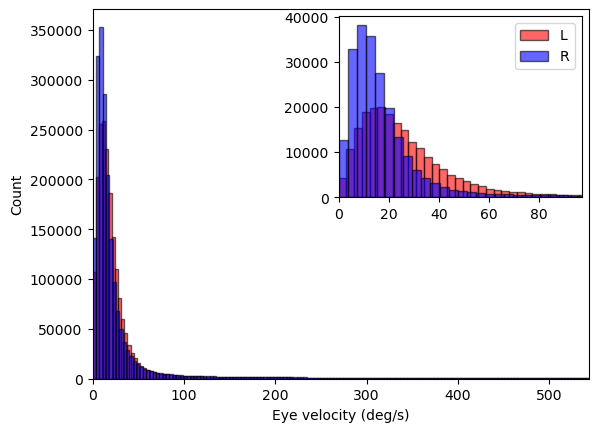

In [369]:
### Eye velocity distribution across all trials, all days
plt.figure()
n_hist_bins = 5000
plt.hist(np.concatenate(left_eye_velocities_all_trials_all_days), bins=n_hist_bins, color='r', edgecolor='k', alpha=0.6, label='L')
plt.hist(np.concatenate(right_eye_velocities_all_trials_all_days), bins=n_hist_bins, color='b', edgecolor='k', alpha=0.6, label='R')
plt.xlim([0, np.percentile(np.nan_to_num(np.concatenate([np.concatenate(left_eye_velocities_all_trials_all_days), np.concatenate(right_eye_velocities_all_trials_all_days)])), 99)])

# Create zoomed inset axes
ax = plt.gca()
axins = inset_axes(ax, width="70%", height="70%", loc="upper right", bbox_to_anchor=(0.3, 0.3, 0.7, 0.7), bbox_transform=ax.transAxes)
axins.hist(np.concatenate(left_eye_trial_data.velocities), bins=n_hist_bins, color='r', edgecolor='k', alpha=0.6, label='L')
axins.hist(np.concatenate(right_eye_trial_data.velocities), bins=n_hist_bins, color='b', edgecolor='k', alpha=0.6, label='R')
axins.set_xlim([0, np.percentile(np.nan_to_num(np.concatenate([np.concatenate(left_eye_velocities_all_trials_all_days), np.concatenate(right_eye_velocities_all_trials_all_days)])), 92.5)])

ax.set_xlabel('Eye velocity (deg/s)')
ax.set_ylabel('Count')
plt.legend()

fig_dir = f'/Users/joseph/Documents/GitHub/figures/eye_trace'
fig_name = f'eye_velocity_hist.png'
if not os.path.exists(f'{fig_dir}/{fig_name}') or overwrite_files:
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)
    plt.savefig(f'{fig_dir}/{fig_name}', bbox_inches='tight')